In [1]:
!CUDA_VISIBLE_DEVICES=3

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import pandas as pd
import random
from scipy import stats
import torch
import seaborn as sns
import sys
sys.path.append('..')
from VAE.VAE_model import VAE
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from tqdm import tqdm
import celltypist

In [3]:
# load the real dataset
real = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/data/tabula_muris/all.h5ad')
real.var_names_make_unique()

sc.pp.filter_genes(real, min_cells=3)
gene_name = real.var_names

sc.pp.normalize_total(real, target_sum=1e4)
real

AnnData object with n_obs × n_vars = 57004 × 18996
    obs: 'celltype', 'n_genes'
    var: 'n_cells'

marker gene expression

In [4]:
# load the dataset that generated by scDiffusion
sim_adata = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/data/generated_muris_cell_all.h5ad')
sim_adata.var_names = gene_name

In [5]:
sim_tmp = sim_adata.copy()
sc.pp.normalize_total(sim_tmp,1e4)
sc.pp.log1p(sim_tmp)
# celltypist is trained on real dataset
predictions = celltypist.annotate(sim_tmp, model = '/data1/lep/Workspace/guided-diffusion/checkpoint/celltypist_muris_all.pkl')
sim_adata.obs['celltype'] = predictions.predicted_labels.squeeze(1).values

🔬 Input data has 57000 cells and 18996 genes


🔗 Matching reference genes in the model
🧬 18996 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


spearman= 0.965034965034965
pearson= 0.9989252266007144


<Figure size 640x480 with 0 Axes>

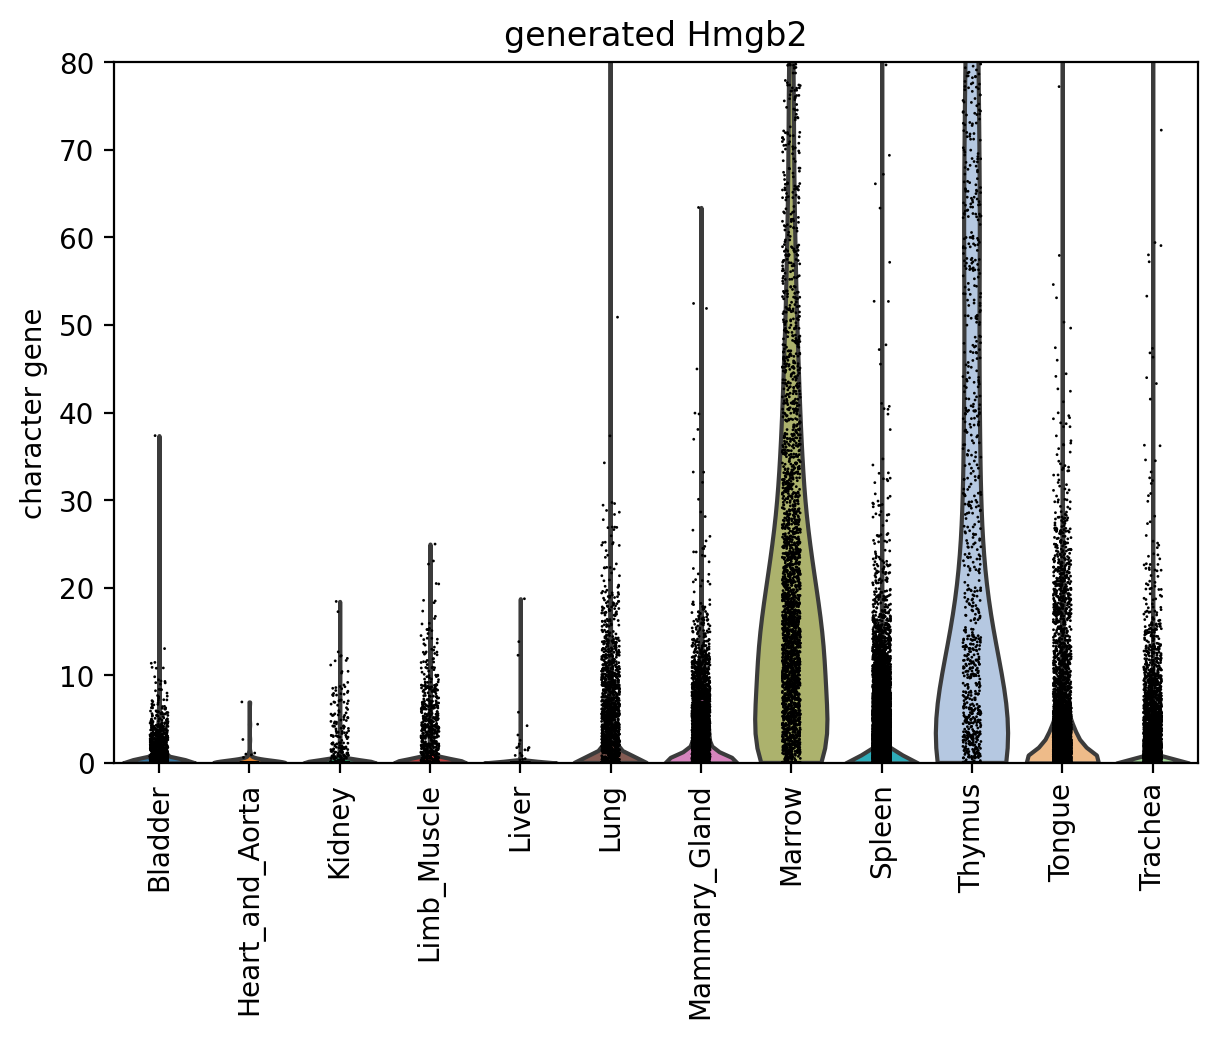

<Figure size 640x480 with 0 Axes>

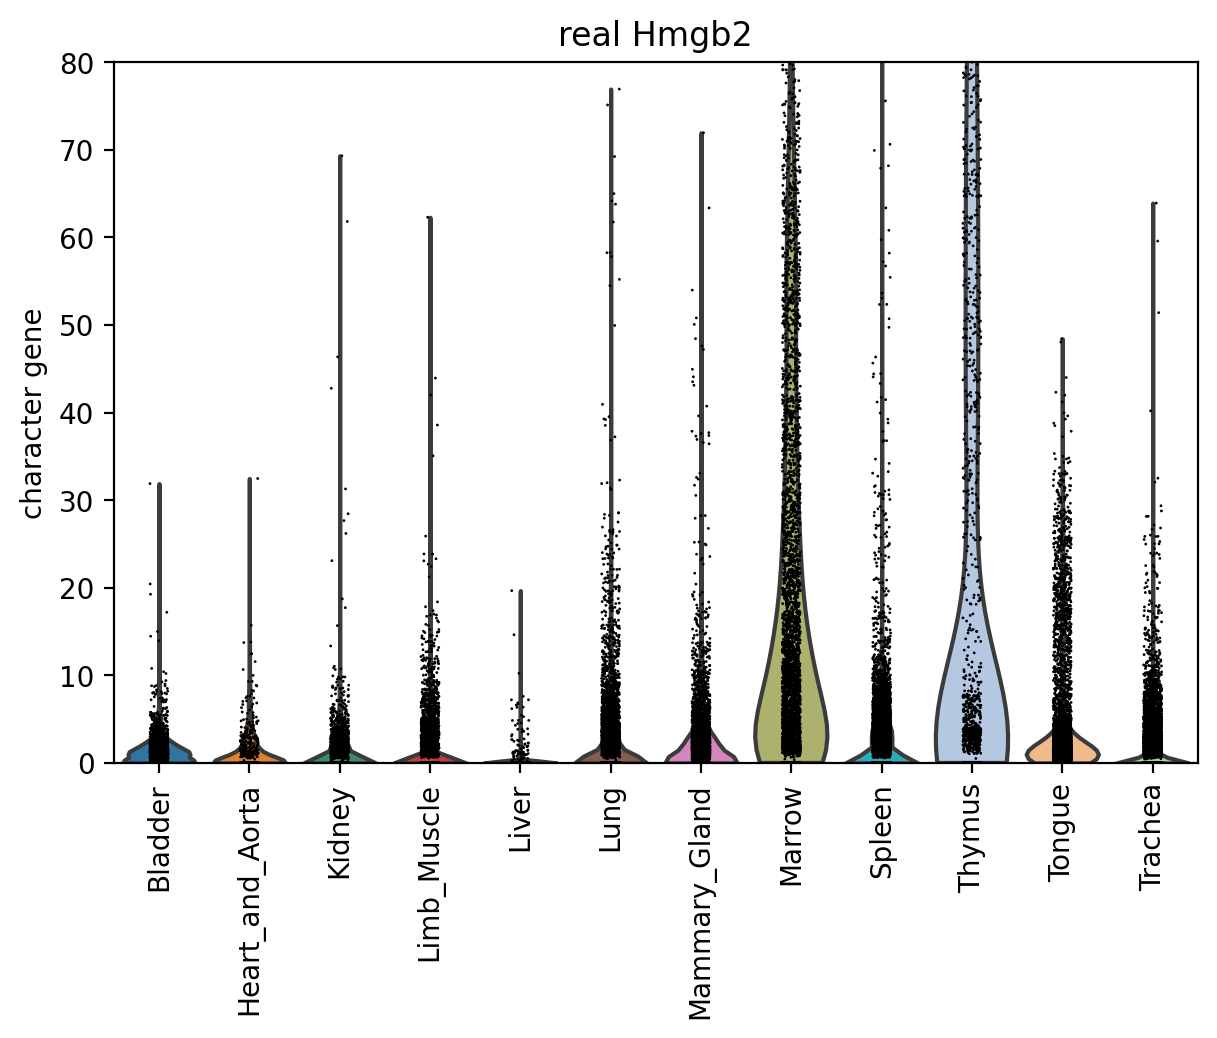

In [6]:
key_tf = ['Klf13','Ybx1','Hnrnpk','Cnbp','Hmgb2']
index = 4

plt.figure()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.violin(sim_adata, keys=[key_tf[index]], groupby='celltype', ylabel='character gene',rotation=90,show=False)
plt.ylim((0,80))
plt.title(f'generated {key_tf[index]}')


plt.figure()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.violin(real, keys=[key_tf[index]], groupby='celltype', ylabel='character gene',rotation=90,show=False)
plt.ylim((0,80))
plt.title(f'real {key_tf[index]}')


marker_of_interest = key_tf[index] 
real_adata = real
  
mean_expression_vector1 = []  
mean_expression_vector2 = []  
  
all_categories = np.unique(real.obs['celltype'].values)
for cell_type in all_categories:  

    adata_tmp1 = real_adata[real_adata.obs['celltype'] == cell_type]
    adata_tmp2 = sim_adata[sim_adata.obs['celltype'] == cell_type]

    index = np.where(adata_tmp1.var_names==marker_of_interest)
    mean_expression_vector1.append(adata_tmp1[:,index[0]].X.mean())
    mean_expression_vector2.append(adata_tmp2[:,index[0]].X.mean())

mean_expression_vector1 = np.array(mean_expression_vector1)  
mean_expression_vector2 = np.array(mean_expression_vector2)

print('spearman=',stats.spearmanr(mean_expression_vector1, mean_expression_vector2).correlation)
print('pearson=',np.corrcoef(mean_expression_vector1, mean_expression_vector2)[0][1])

qq plot

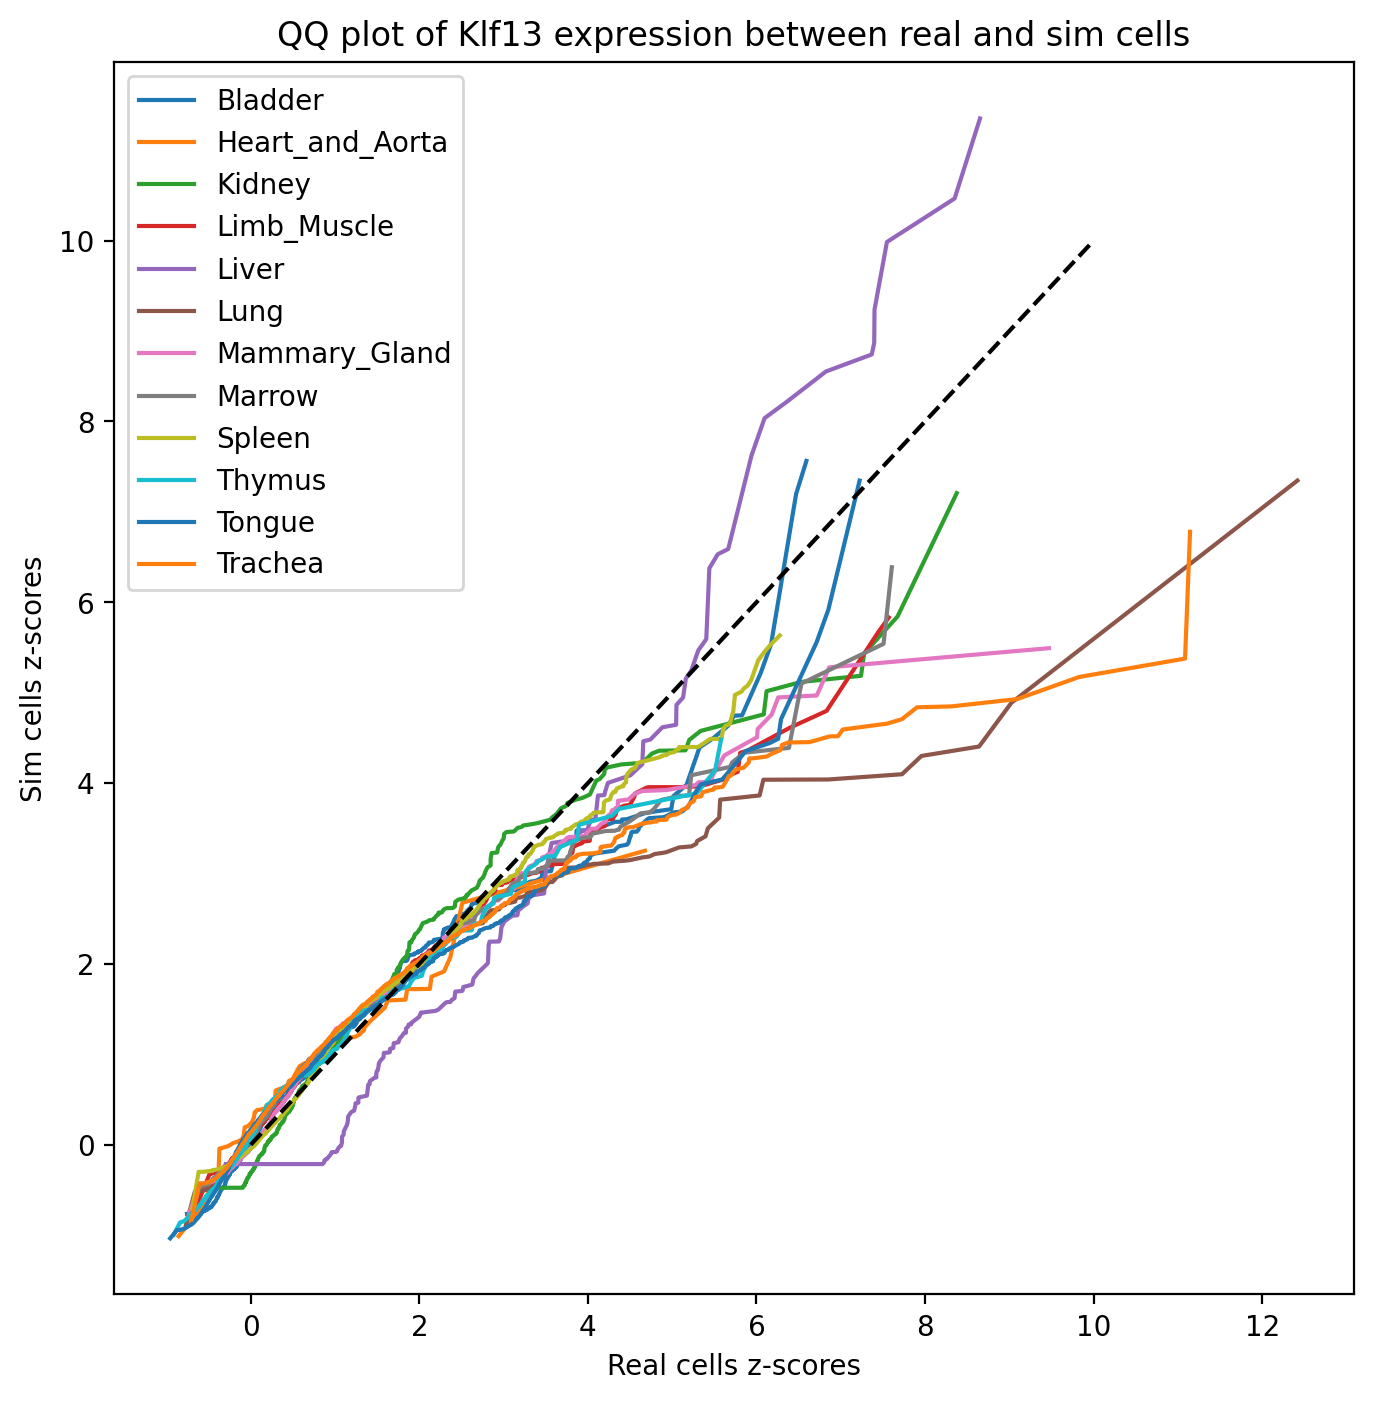

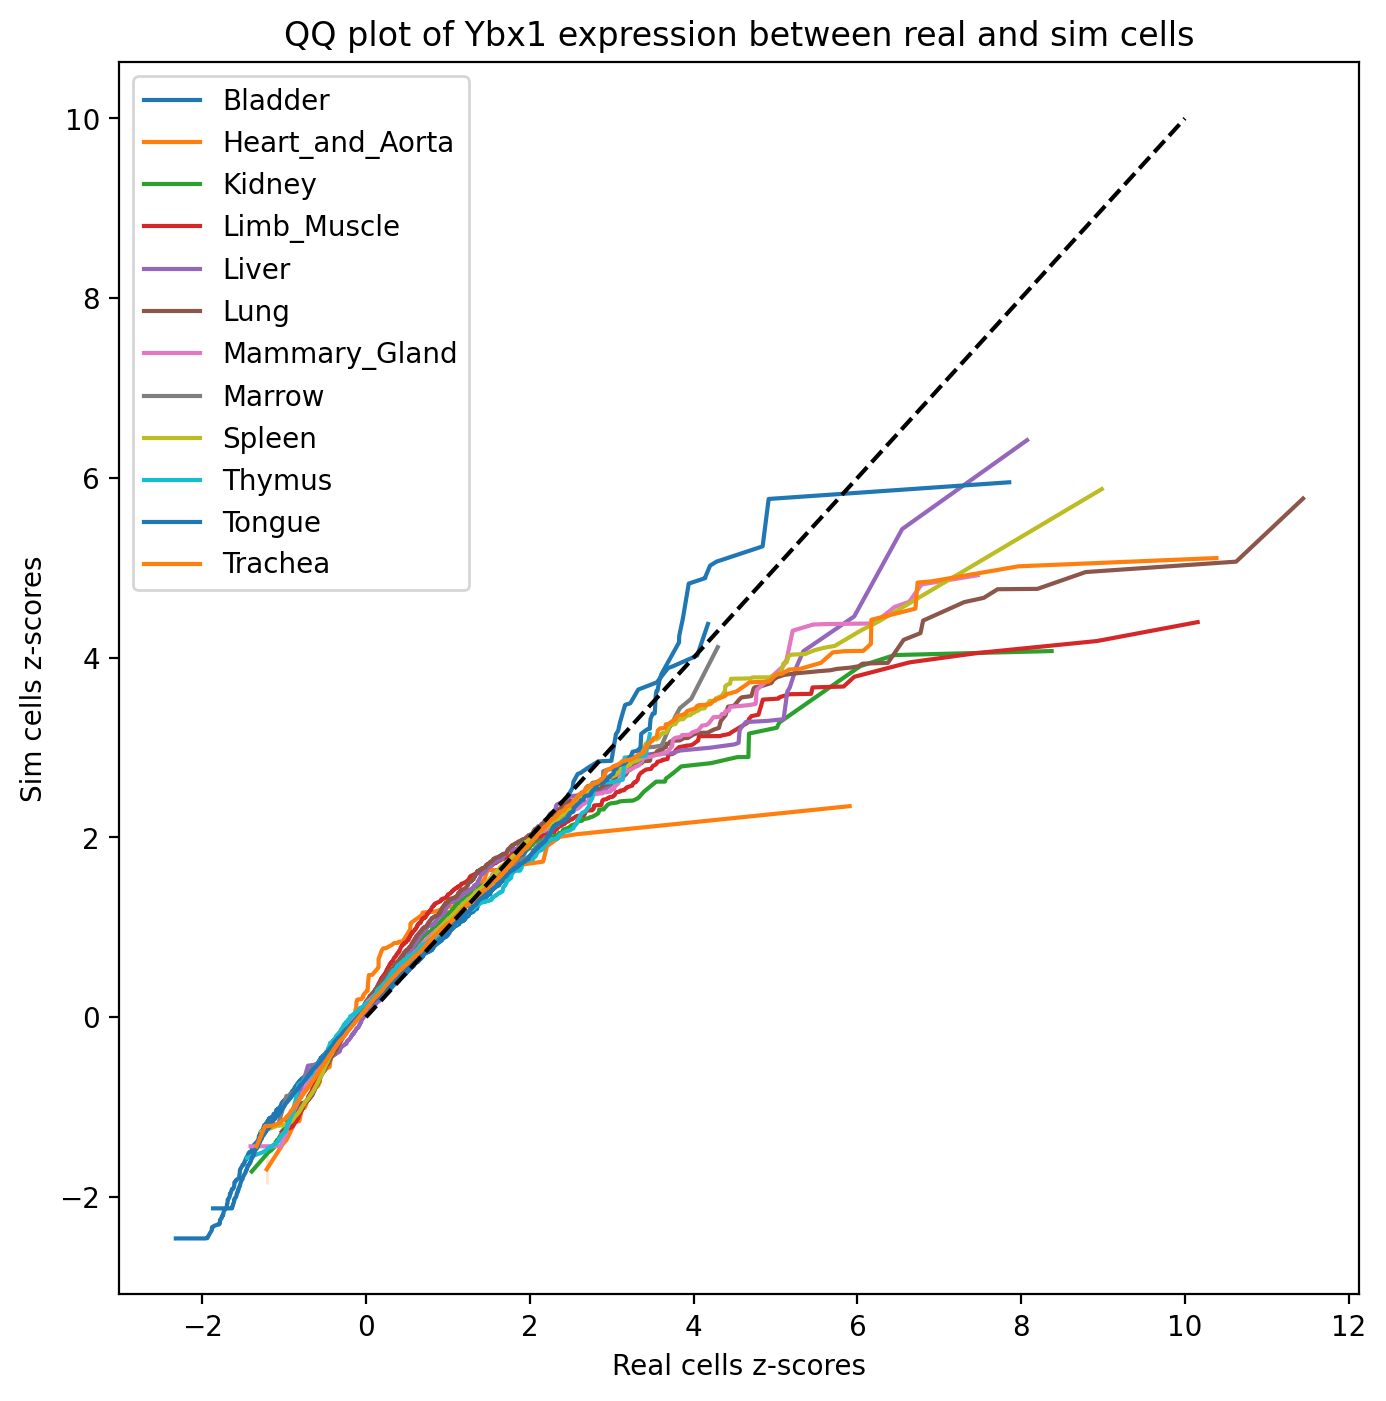

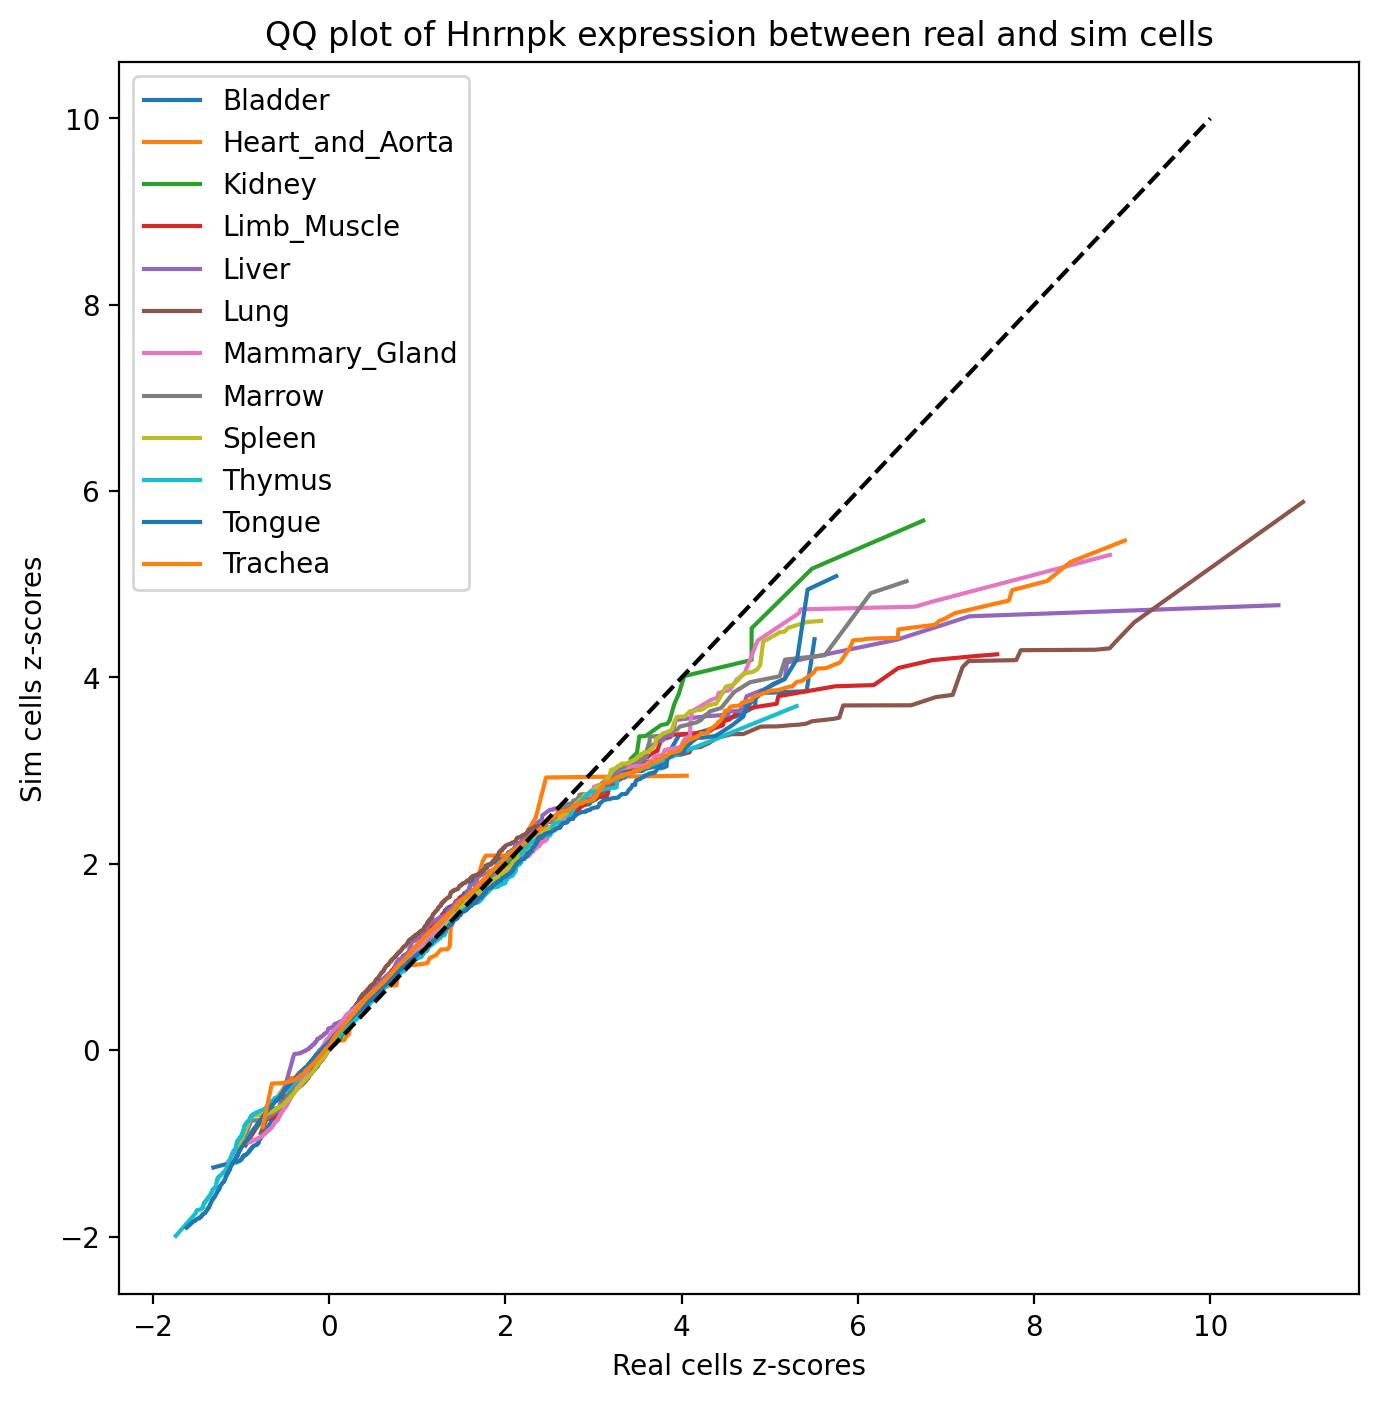

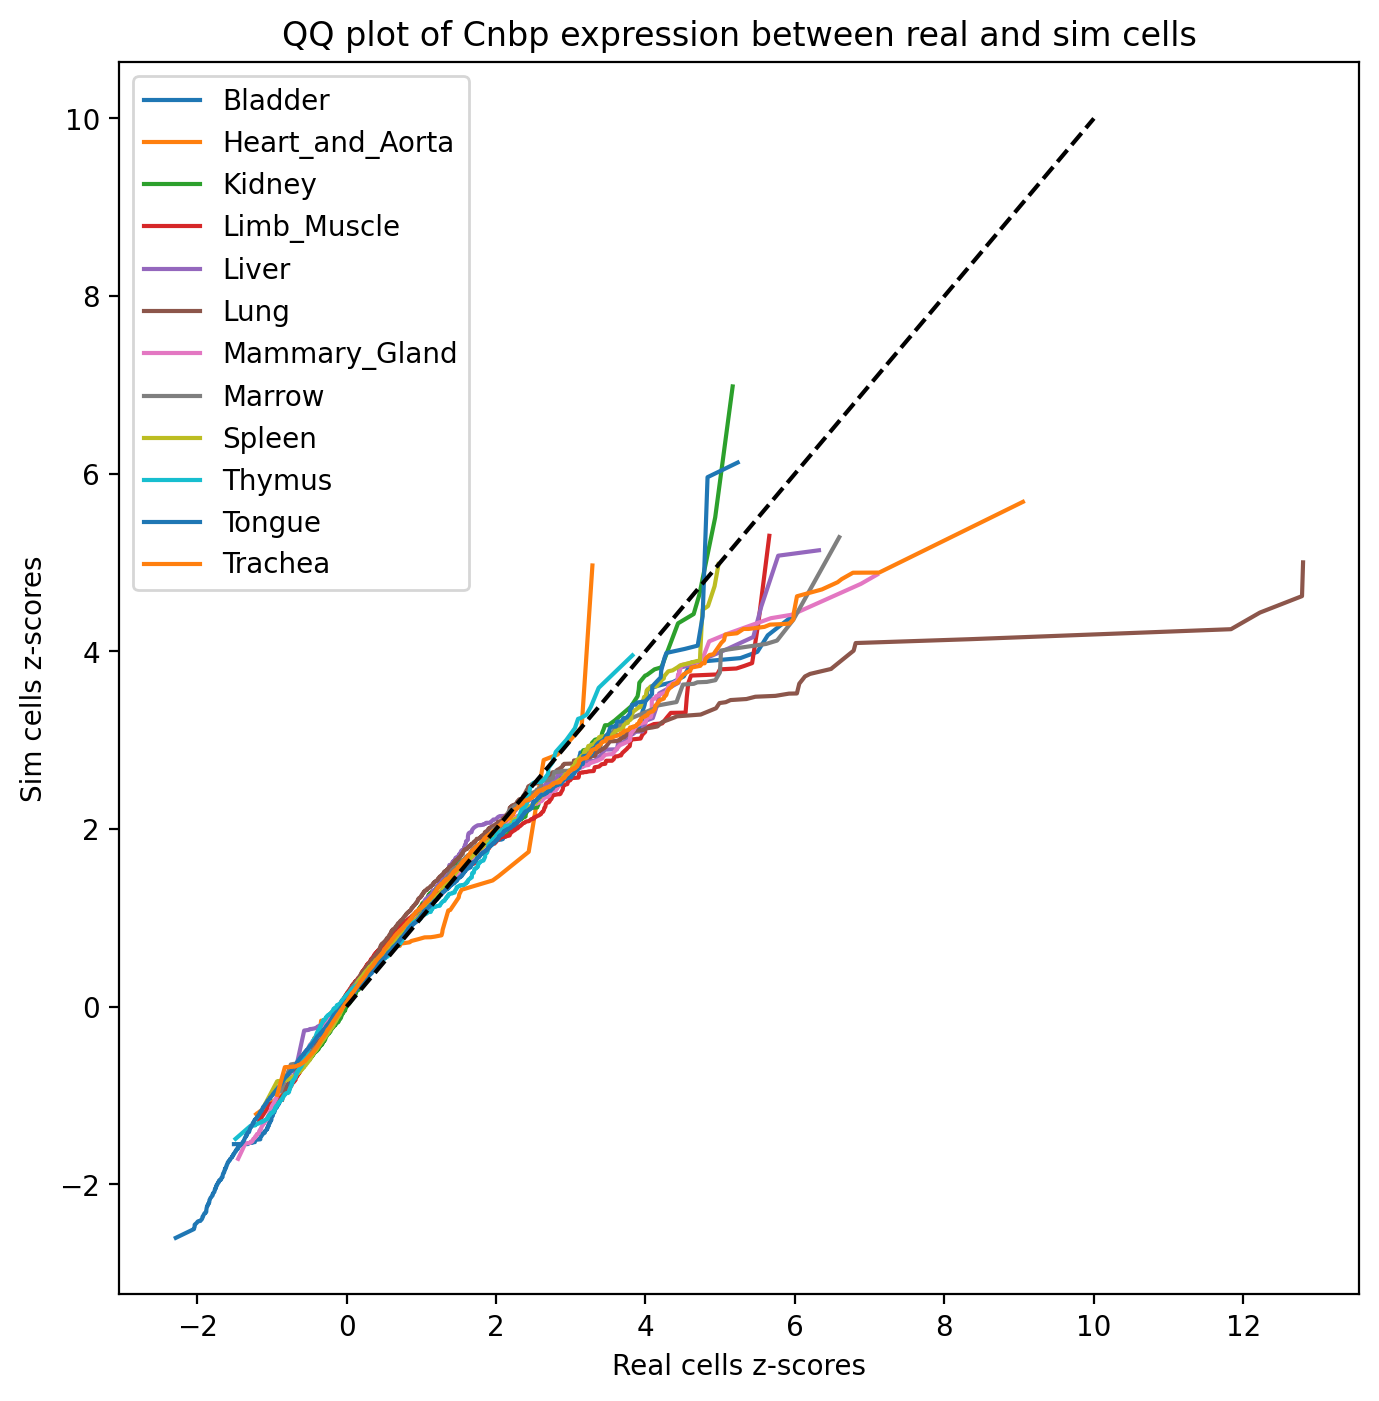

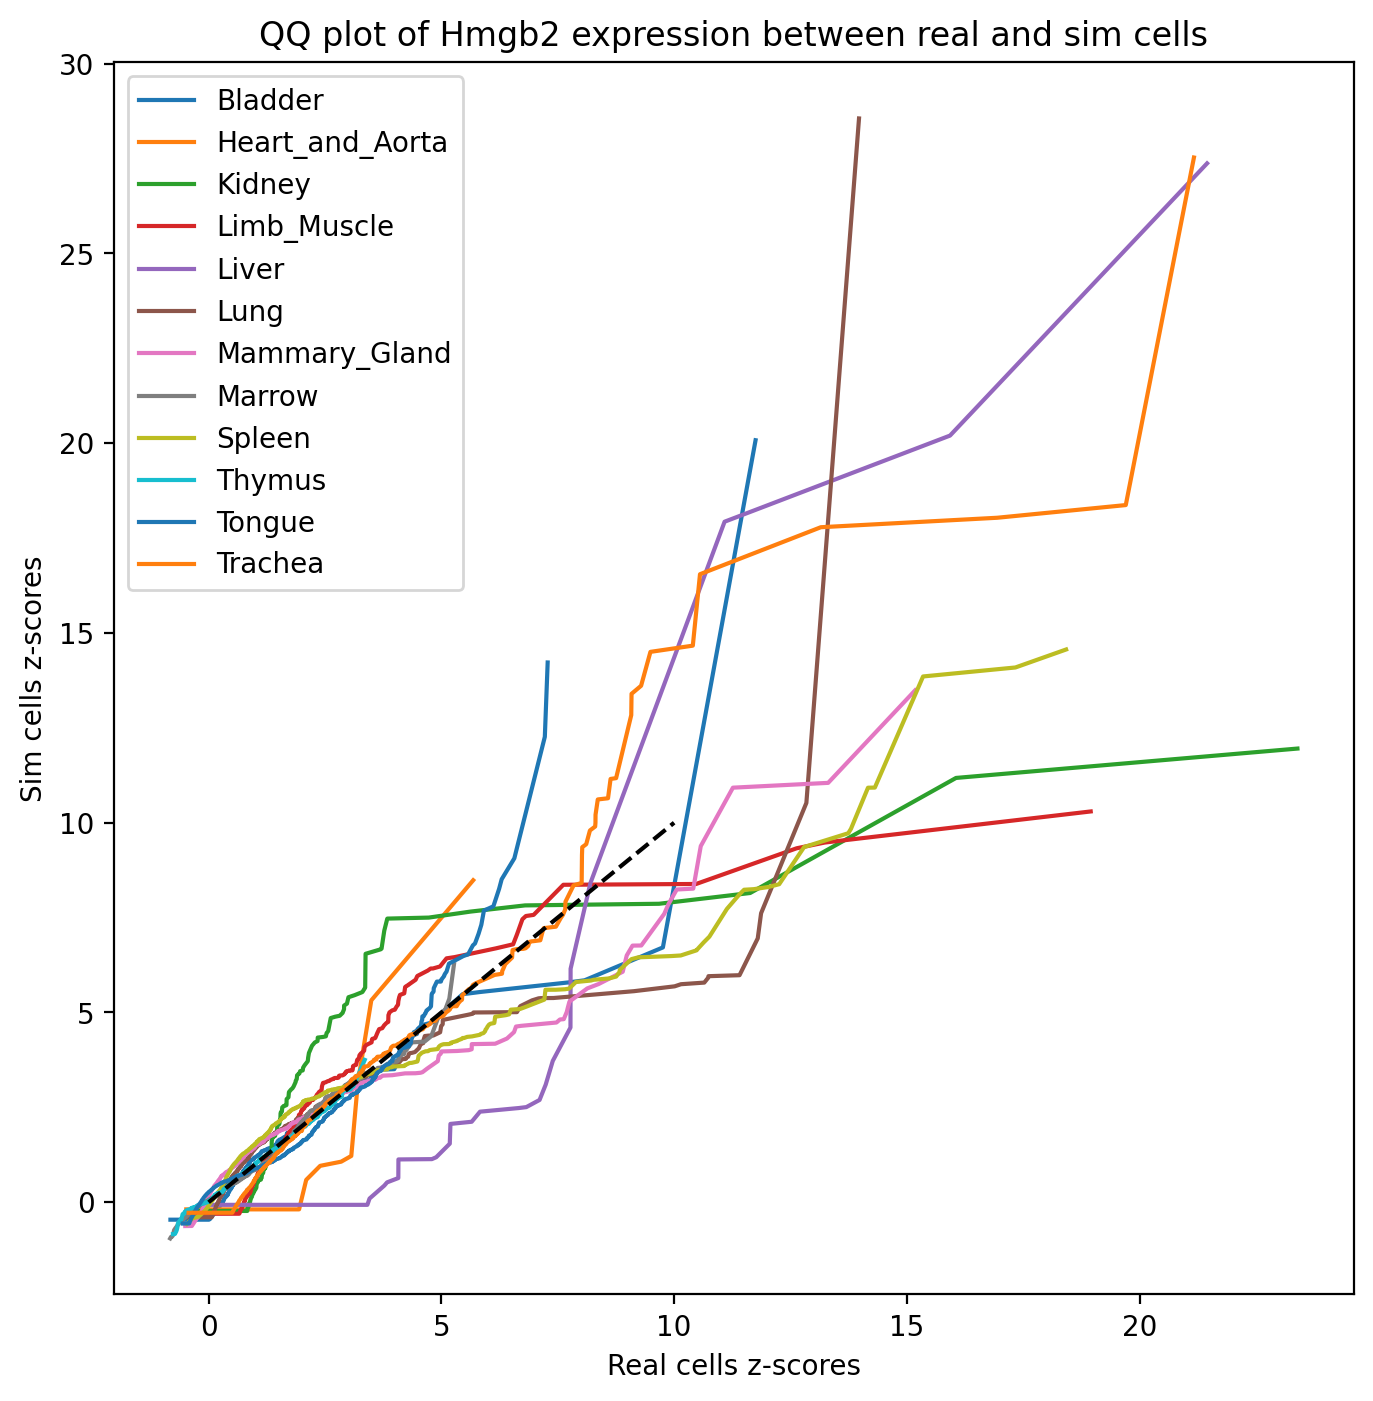

In [7]:
import scipy.stats as stats  
  
key_tf = ['Klf13','Ybx1','Hnrnpk','Cnbp','Hmgb2']

for i in range(len(key_tf)):

    gene_of_interest = key_tf[i]
    gene_index = sim_adata.var_names.tolist().index(gene_of_interest)  

    plt.figure(figsize=(8, 8))

    for type in np.unique(sim_adata.obs['celltype']):

        a = real[real.obs['celltype'] == type]
        b = sim_adata[sim_adata.obs['celltype'] == type]
        size = min(a.X.toarray().shape[0],b.X.toarray().shape[0])
        real_gene_expression = a[:size, gene_index].X.toarray().squeeze(-1)  
        sim_gene_expression = b[:size, gene_index].X.toarray().squeeze(-1)  

        real_gene_z_scores = stats.zscore(real_gene_expression)  
        sim_gene_z_scores = stats.zscore(sim_gene_expression)  

        real_gene_z_scores_sorted = np.sort(real_gene_z_scores)  
        sim_gene_z_scores_sorted = np.sort(sim_gene_z_scores)  

        sns.lineplot(x=real_gene_z_scores_sorted, y=sim_gene_z_scores_sorted, label=type) #,edgecolor="none" 

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.xlabel("Real cells z-scores")  
    plt.ylabel("Sim cells z-scores") 
    plt.legend(loc="upper left") #np.unique(type1),
    plt.title(f"QQ plot of {gene_of_interest} expression between real and sim cells")  
    plt.plot([0,10], [0,10], linestyle="--",color='black')  

